## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(100)

cv2.destroyAllWindows()

In [2]:
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
       
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
    
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    
    return undist


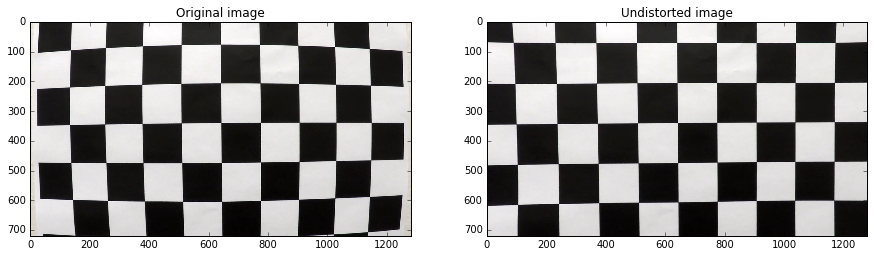

In [3]:
%matplotlib inline

image = cv2.imread(images[0])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
undist = cal_undistort(image,objpoints,imgpoints)


plt.figure(figsize = (15,20))
plt.subplot(1,2,1)

plt.title('Original image')
plt.imshow(image)

plt.subplot(1,2,2)

plt.title("Undistorted image")
plt.imshow(undist)

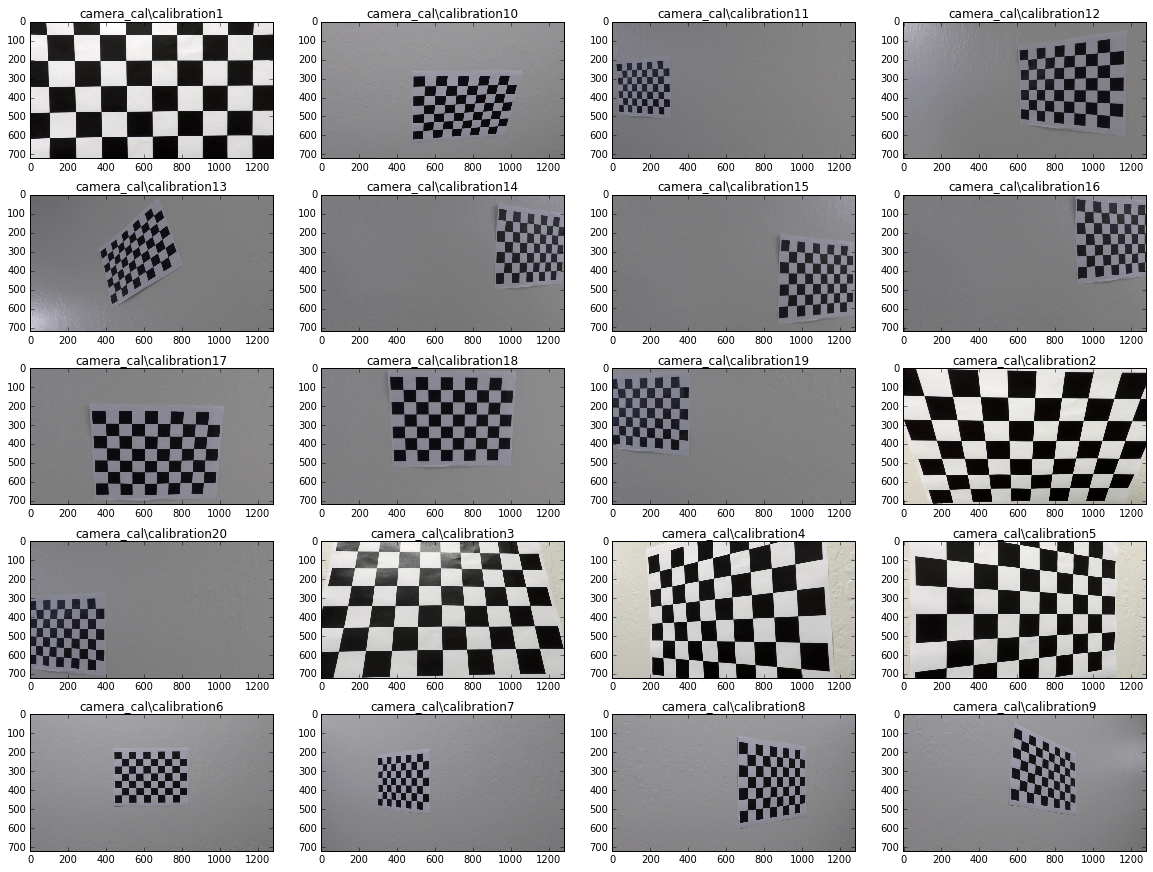

In [4]:
f,axs = plt.subplots(5,4,figsize=(20,15))

for fname,ax in zip(images,axs.flatten()):
    
    image_name = fname.split('/')[-1].split('.')[0]
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    undist = cal_undistort(img,objpoints,imgpoints)
    ax.set_title(image_name)
    ax.imshow(undist)


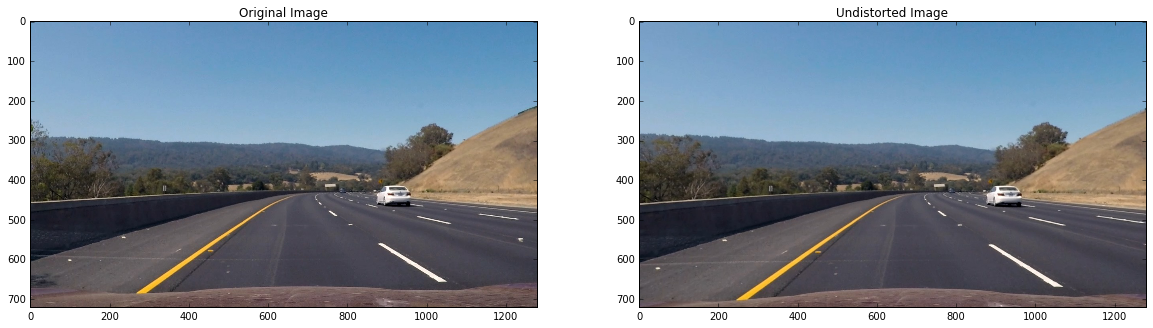

In [5]:
img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_undist = cal_undistort(img,objpoints,imgpoints)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(1,2,2)
plt.title('Undistorted Image')
plt.imshow(img_undist)

In [6]:
def threshold_hls_sobel(image,s_thresh_min=170,s_thresh_max=255,sx_thresh_min = 40,sx_thresh_max=100,display = False):
    # Convert to HLS color space and separate the S channel
    hls_image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    s_channel = hls_image[:,:,2]
        
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh_min) & (scaled_sobel <= sx_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sx_binary), sx_binary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    
    if display:
        
        #display images
        display_image = {'Original':image,'HLS':hls_image,'Sobel x ':scaled_sobel,'S thresh':s_binary,'Sx thresh':sx_binary,'Combined':combined_binary}
        
        fig,axes = plt.subplots(2,3,figsize=(20,8))
        
        for dic,ax in zip(display_image.items(),axes.flatten()):
            ax.set_title(dic[0])
            if (np.shape(dic[1])[-1] == 3):
                ax.imshow(dic[1])
            else:
                ax.imshow(dic[1],'gray') 
    
    return combined_binary


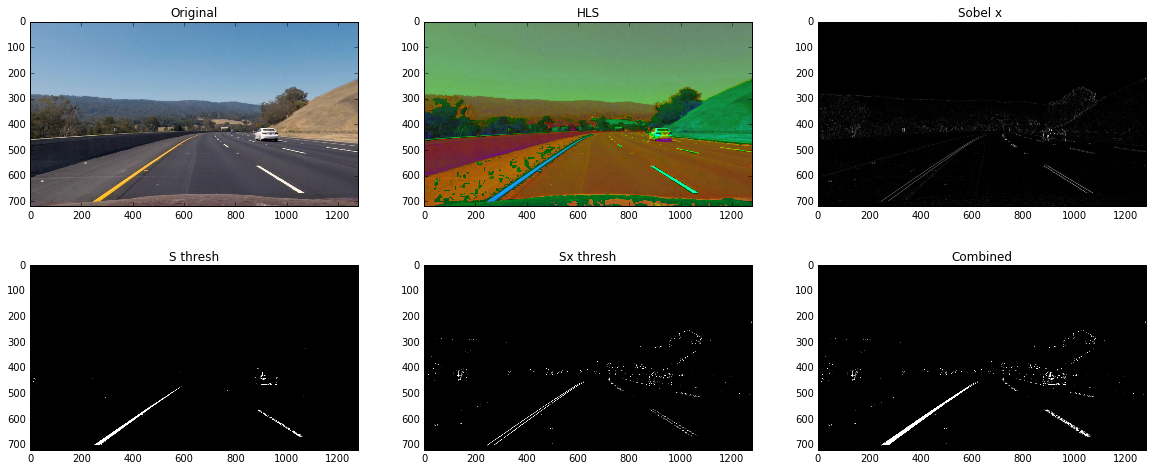

In [7]:
threshold_image = threshold_hls_sobel(img_undist,s_thresh_min=170,s_thresh_max=255,sx_thresh_min = 50,sx_thresh_max=100,display=True)

In [8]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def draw_line(img,point0,point1):
    
    image = img
    line_img = np.zeros_like(image)
    #draw lines
    cv2.line(line_img,point0,point1,[255,0,0],thickness =5) 
    draw_image = weighted_img(image,line_img)
    
    return draw_image


In [9]:
def warp_img(undist,warp = True,display=False):
    
    # get size of image
    ysize = undist.shape[0]
    xsize = undist.shape[1]

    # edge points of interest regions
    left_bottom = [220,ysize]
    right_bottom = [1150,ysize]
    left_apex =[int(0.46*xsize),int(0.65*ysize)]#[int(0.46*xsize),int(0.65*ysize)]
    right_apex = [int(0.58*xsize),int(0.65*ysize)]#[int(0.58*xsize),int(0.65*ysize)]


    # For source points I'm grabbing the outer four detected corners

    src = np.float32([left_apex,right_apex,right_bottom,left_bottom])

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[0.2*xsize,0],[0.8*xsize,0],[0.8*xsize,ysize],[0.2*xsize,ysize]])

    
    if warp :
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, (xsize,ysize))
    
    else :
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(dst,src)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, (xsize,ysize))
    
    if display :
        
        undist_image = draw_line(undist,tuple(left_bottom),tuple(left_apex))
        undist_image = draw_line(undist_image,tuple(left_apex),tuple(right_apex))
        undist_image = draw_line(undist_image,tuple(right_apex),tuple(right_bottom))
        undist_image = draw_line(undist_image,tuple(right_bottom),tuple(left_bottom))
        
        warped_image = draw_line(warped,(int(0.2*xsize),0),(int(0.2*xsize),ysize))
        warped_image = draw_line(warped_image,(int(0.8*xsize),0),(int(0.8*xsize),ysize))

        # Plotting prespective images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Undistorted image')
        ax1.imshow(undist_image)

        ax2.set_title('Prespective transform')
        ax2.imshow(warped_image)
    
    # Return the resulting image and matrix
    return warped, M

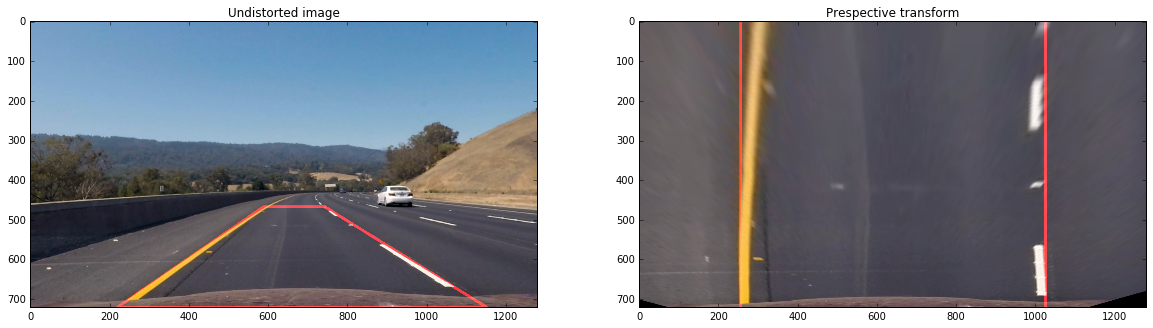

In [10]:
top_down_image,perspective_M = warp_img(img_undist,display=True)

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window 
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin 
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If  found > minpix pixels, recenter next window 
        #(`right` or `leftx_current`) on their mean position 
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped,draw = False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    if draw :
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fit,right_fit,ploty


left_fit: [  6.32141310e-05  -1.04204940e-01   3.05049535e+02]
right_fit ： [  1.56581666e-04  -1.13033276e-01   1.01902197e+03]


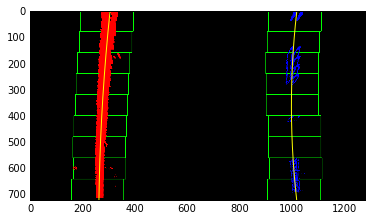

In [12]:
thresh_image = threshold_hls_sobel(img_undist,s_thresh_min=160,s_thresh_max=255,sx_thresh_min = 30,sx_thresh_max=100)

binary_warped,_ = warp_img(thresh_image)

out_img,left_fit_,right_fit_,ploty_ = fit_polynomial(binary_warped,draw = True)
plt.imshow(out_img)

print ("left_fit:",left_fit_)
print ("right_fit ：",right_fit_)

In [13]:
def measure_curvature(l_fit,r_fit,ploty,x_mid,real=False):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit = np.zeros_like(l_fit)
    right_fit = np.zeros_like(r_fit)
    
    left_fit[0] = l_fit[0] 
    left_fit[1] = l_fit[1] 
    left_fit[2] = l_fit[2]

    right_fit[0] = r_fit[0]
    right_fit[1] = r_fit[1]
    right_fit[2] = r_fit[2] 
    
    x_middle = x_mid

    # real data
    if real :
        
        left_fit[0] = l_fit[0] * (xm_per_pix / (ym_per_pix **2))
        left_fit[1] = l_fit[1] * (xm_per_pix / (ym_per_pix))
        left_fit[2] = l_fit[2] * (xm_per_pix )

        right_fit[0] = r_fit[0] * (xm_per_pix / (ym_per_pix **2))
        right_fit[1] = r_fit[1] * (xm_per_pix / ym_per_pix)
        right_fit[2] = r_fit[2] * (xm_per_pix)
        ploty = ploty * ym_per_pix   
        
        x_middle = x_mid * xm_per_pix
 
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)    
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    #calculate offset
    left_point = left_fit[0]*(y_eval**2)+left_fit[1]*y_eval+left_fit[2]
    right_point = right_fit[0] * (y_eval **2)+right_fit[1]*y_eval + right_fit[2]
    min_point = (left_point + right_point)/2.0
    
    vehicle_offset = x_middle - min_point
    
    return left_curverad, right_curverad,vehicle_offset

In [14]:
left_curverad,right_curverad,vehicle_offset= measure_curvature(left_fit_,right_fit_,ploty_,binary_warped.shape[1]/2,real=True)

print ("left curverad is : ",left_curverad)
print ("right curverad is : ",right_curverad)
print ("vehicle offset is : ",vehicle_offset)


left curverad is :  2597.95437639
right curverad is :  1049.14309801
vehicle offset is :  -0.00397243930551


In [15]:
def search_around_pixels(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 80

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    
    return leftx,lefty,rightx,righty

In [16]:
# Load our image - this should be a new frame since last time!
#binary_warped = mpimg.imread('warped_example.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)#None
    right_fit = np.polyfit(righty,rightx,2)#None
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]#None
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]#None
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit,right_fit,draw=False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if draw :
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    
    return result,left_fitx,right_fitx,ploty


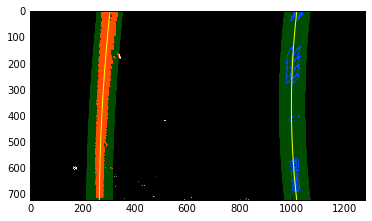

In [17]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

left_fit = np.polyfit(lefty,leftx,2)
right_fit = np.polyfit(righty,rightx,2)

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,_,_,_ = search_around_poly(binary_warped,left_fit,right_fit,draw=True)

# View your output
plt.imshow(result)

In [18]:
def output_img(undist_image):
    
    threshold_bin = threshold_hls_sobel(undist_image)
    warped_bin,_ = warp_img(threshold_bin)
    
    out_img,left_fit,right_fit,ploty = fit_polynomial(warped_bin)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    
    warp_zero = np.zeros_like(warped_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp,_= warp_img(color_warp,warp = False)
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
    x_middle = warped_bin.shape[1]/2
    left_curverad,right_curverad,vehicle_offset= measure_curvature(left_fit,right_fit,ploty,x_middle,real=True)
    
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    if (vehicle_offset > 0):
        offset_text = 'Vehicle is {:.2f}m {} of center'.format(np.abs(vehicle_offset),'right')
    elif (vehicle_offset < 0):
        offset_text = 'Vehicle is {:.2f}m {} of center'.format(np.abs(vehicle_offset),'left')
    else :
        offset_text = 'Vehicle is {:.2f}m of center'.format(np.abs(vehicle_offset))
    
    left_text = 'Left Curvature :{:.2f}(m)'.format(left_curverad)
    right_text = 'Right Curvature :{:.2f}(m)'.format(right_curverad)
    
    cv2.putText(result,left_text,(100,100),font,2,(255,255,255),2)
    cv2.putText(result,right_text,(100,160),font,2,(255,255,255),2)
    cv2.putText(result,offset_text,(100,220),font,2,(255,255,255),2)
    
    return result

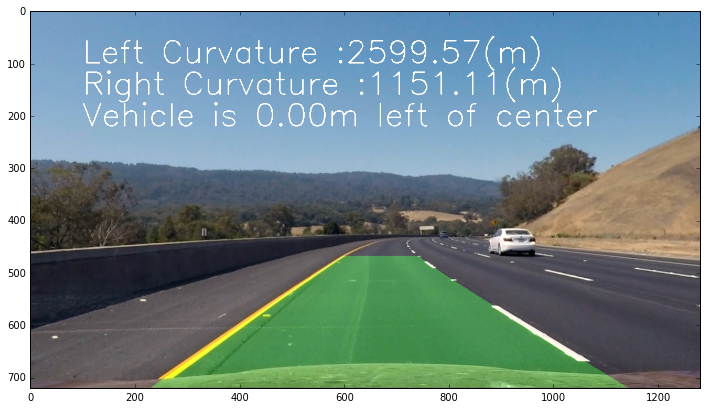

In [19]:
plt.figure(figsize=(12,8))
res_ = output_img(img_undist)


plt.imshow(res_)

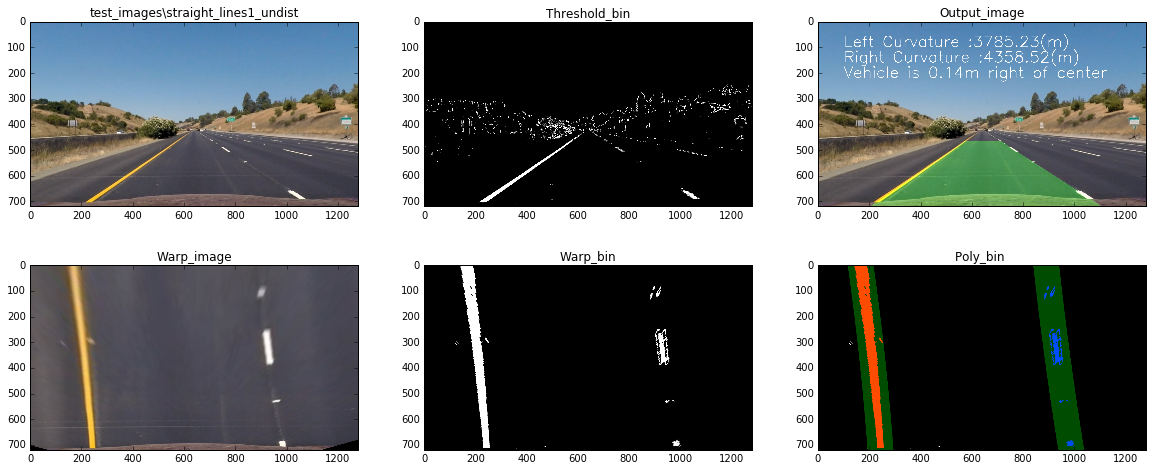

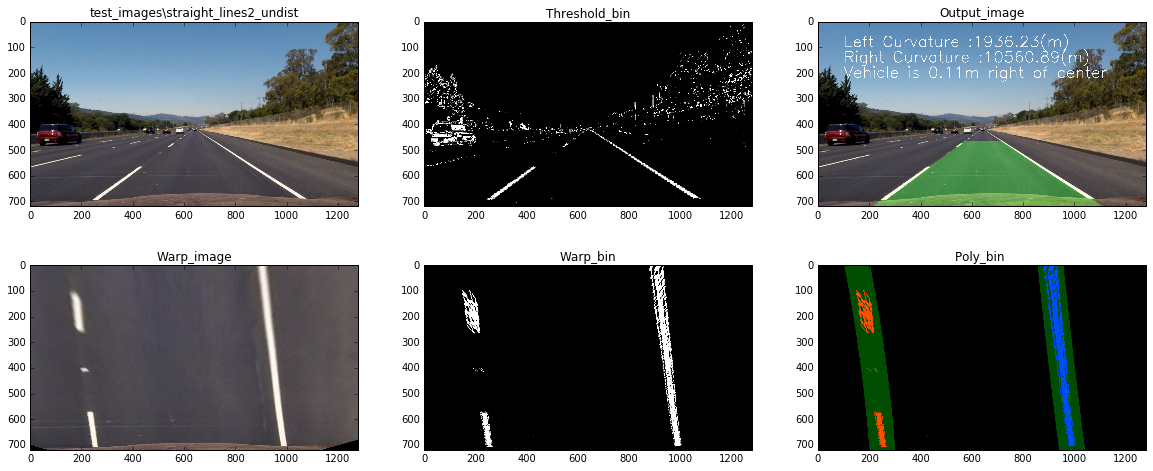

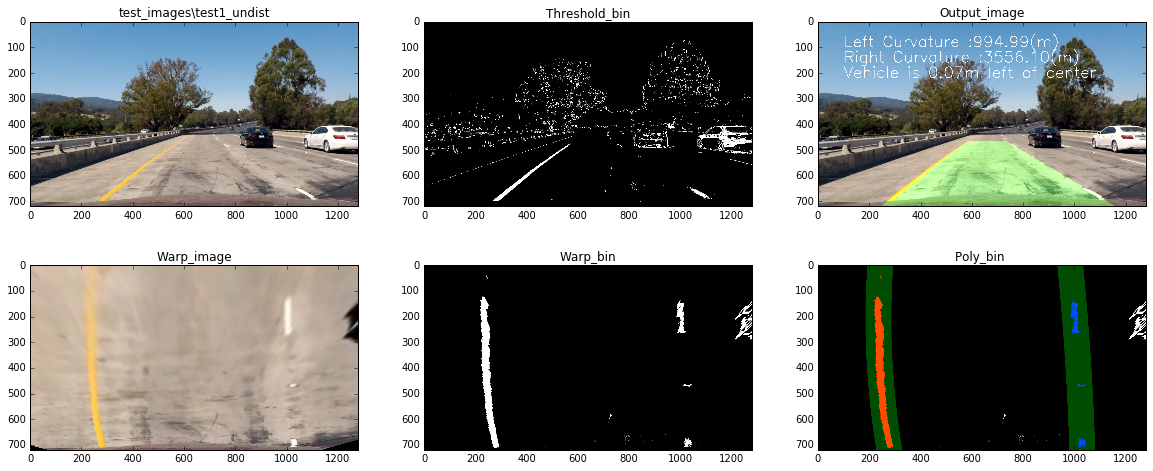

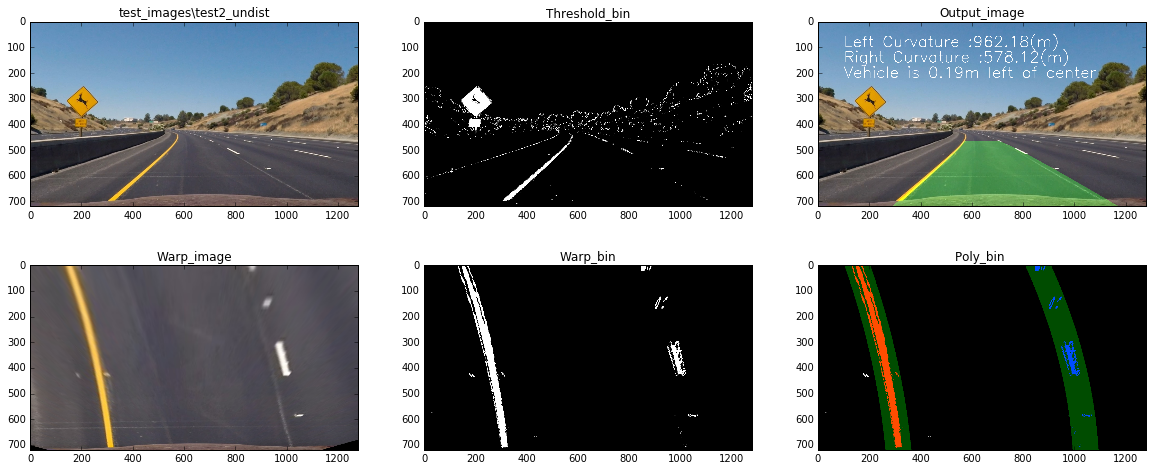

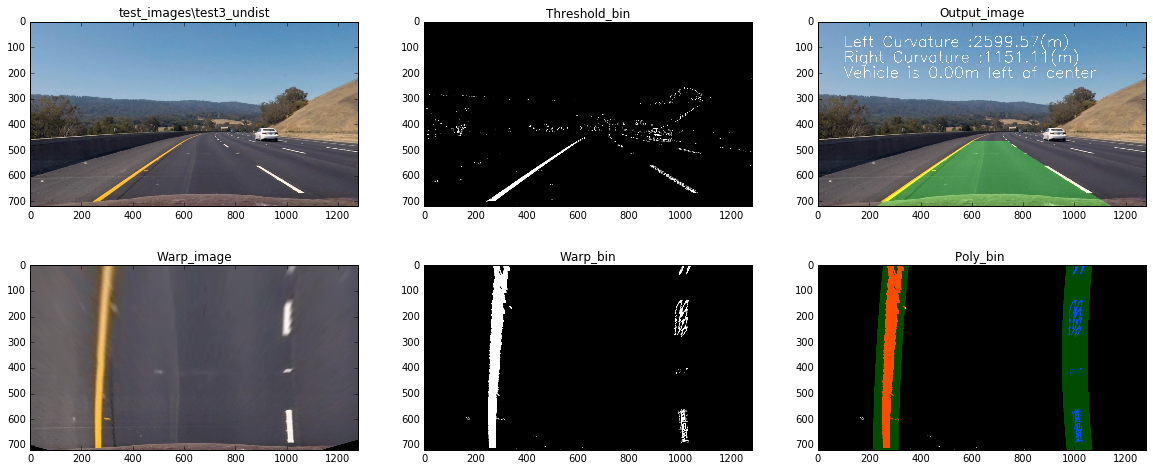

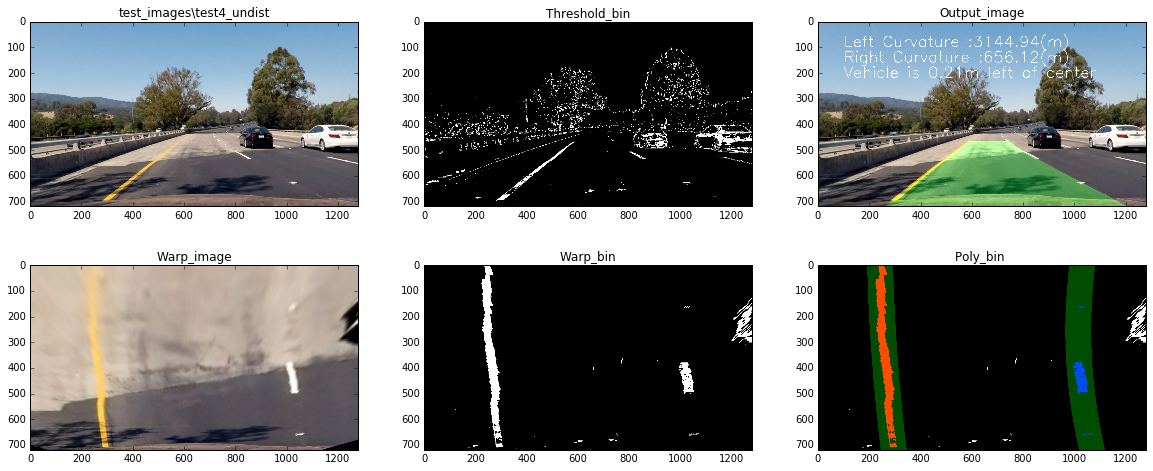

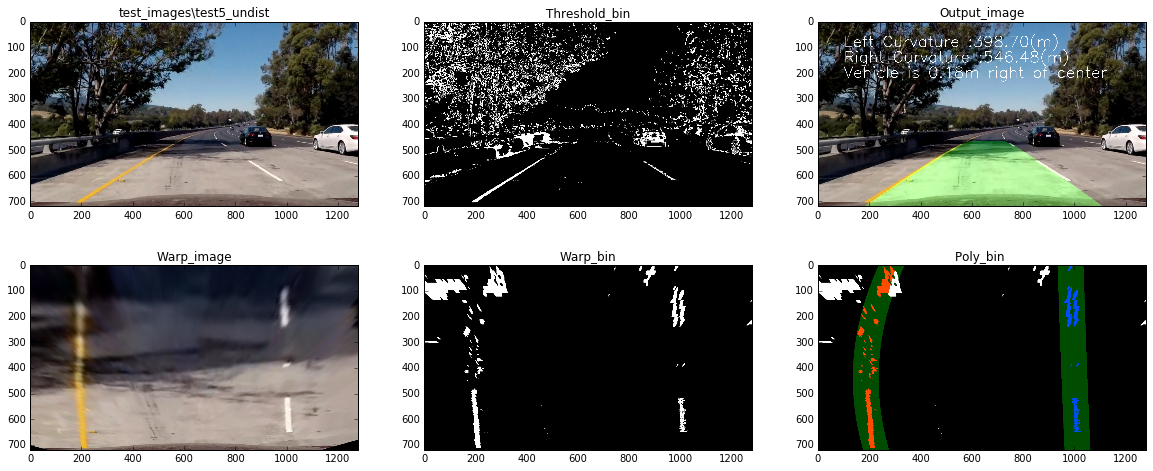

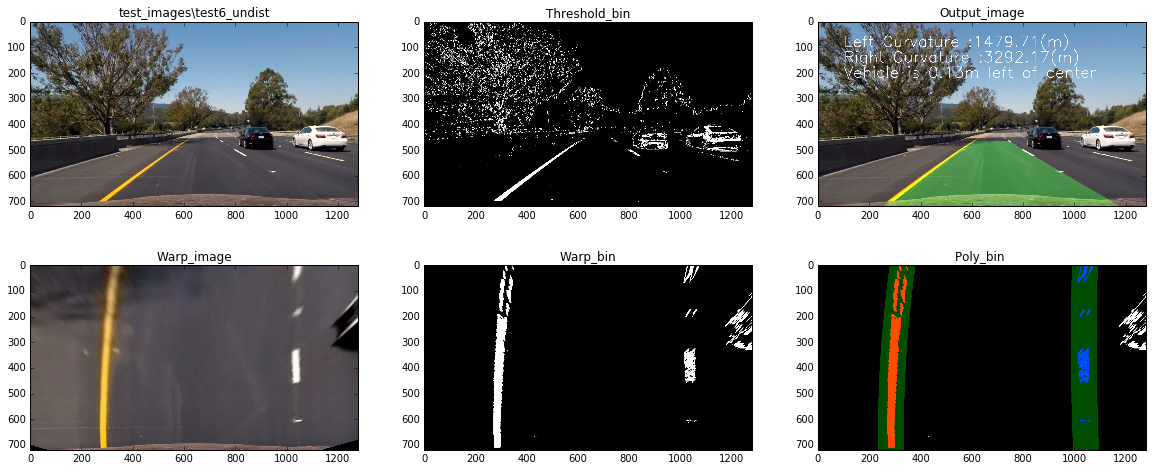

In [20]:
test_image_names = glob.glob('./test_images/*.jpg')

for fname in test_image_names:
    
    test_name = fname.split('/')[-1].split('.')[0]
    image_test = cv2.imread(fname)
    image_test = cv2.cvtColor(image_test,cv2.COLOR_BGR2RGB)
    
    image_undist = cal_undistort(image_test,objpoints,imgpoints)
    
    image_bin = threshold_hls_sobel(image_undist)
    image_warp_bin,_ = warp_img(image_bin)
    image_warp,_ = warp_img(image_undist)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(image_warp_bin)

    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
    image_poly_bin,_,_,_ = search_around_poly(image_warp_bin,left_fit,right_fit)
    
    image_output = output_img(image_undist)
    
    display_image = {'{}_undist'.format(test_name):image_undist,
                     'Threshold_bin':image_bin,
                     'Output_image':image_output,
                     'Warp_image':image_warp,
                     'Warp_bin':image_warp_bin,
                     'Poly_bin ':image_poly_bin}
        
    fig,axes = plt.subplots(2,3,figsize=(20,8))

    for dic,ax in zip(display_image.items(),axes.flatten()):
        ax.set_title(dic[0])
        if (np.shape(dic[1])[-1] == 3):
            ax.imshow(dic[1])
        else:
            ax.imshow(dic[1],'gray') 
    

In [21]:
def multi_img (image,image1,image2,image3):

    output_img = np.zeros_like(image)

    xsize = image.shape[1]//2
    ysize = image.shape[0]//2
    
    image00 = cv2.resize(image,(xsize,ysize))
    image01 = cv2.resize(image1,(xsize,ysize))
    image02 = cv2.resize(image2,(xsize,ysize))
    image03 = cv2.resize(image3,(xsize,ysize))

    output_img[:ysize,:xsize,:] = image00
    output_img[:ysize,xsize:,:] = image01
    output_img[ysize:,:xsize,:] = image02
    output_img[ysize:,xsize:,:] = image03

    return output_img


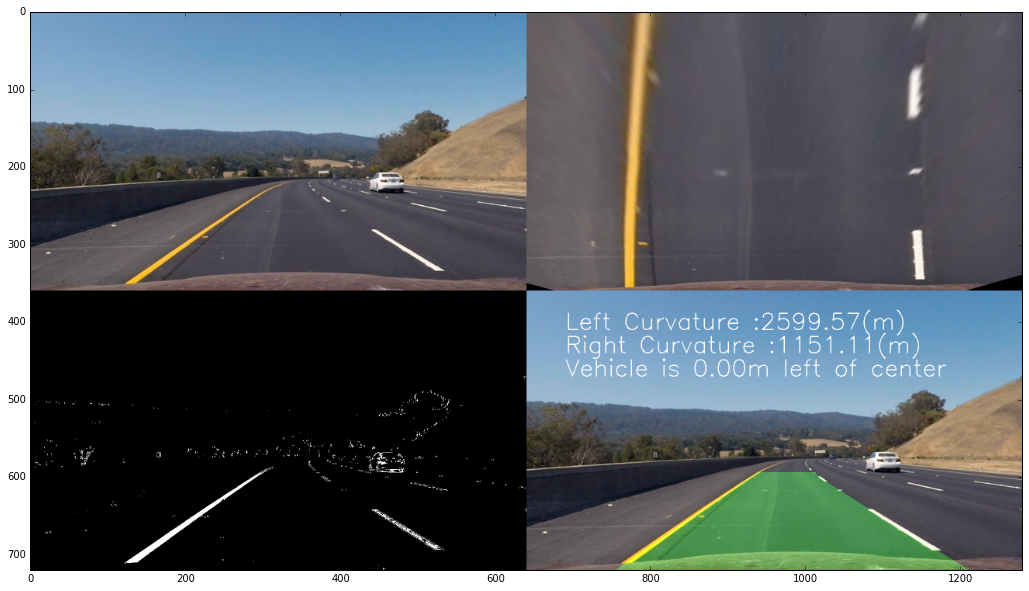

In [22]:
threshold = np.dstack((threshold_image,threshold_image,threshold_image)) * 255
_image = multi_img(img_undist,top_down_image,threshold,res_)
plt.figure(figsize=(20,10))
plt.imshow(_image)

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
        

In [25]:
def fillpoly (image,left_fitx,right_fitx,ploty,color = 'g'):
        
    if (len(image.shape) < 3):
        warp_zero = np.zeros_like(image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    else :
        color_warp = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    
    if color == 'r':
        cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
    elif color == 'g':
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    elif color == 'b':
        cv2.fillPoly(color_warp, np.int_([pts]), (0,0,255))
    
    return color_warp
    

In [26]:
def pred_fit(line_fit):
    
    line_fits = np.array(line_fit)
    
    plotx = np.arange(0,len(line_fit))
    plotx1 = len(line_fit)
    
    next_fit = []
            
    for i in range(line_fits.shape[1]):
        
        fit_i = np.polyfit(plotx,line_fits[:,i],2)
        pred_y = fit_i[0]*plotx1**2 + fit_i[1]*plotx1 +fit_i[2]
        next_fit.append(pred_y)
        
    
    return next_fit

In [27]:
def judge_line(image_shape,left_fitx,right_fitx):
    
    x_size = image_shape[1]
    y_size = image_shape[0]
    
    sample = np.arange(y_size-1,0,-(y_size/10.)).astype(np.uint32)
    offset = right_fitx[sample] - left_fitx[sample]
    
    detect = False
    
    if abs(np.mean((right_fitx[-1],left_fitx[-1])) - x_size/2.) < 80:

        if np.std(offset) < 40:

            detect = True
    

    return detect,abs((right_fitx[-1] + left_fitx[-1])/2.-x_size/2.),np.std(offset)
    
    

In [31]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # undistorted
    image_undist = cal_undistort(image,objpoints,imgpoints)
    
    #prespected transform
    warped_image,_ = warp_img(image_undist)
    
    # color and gradient threshold
    threshold_warped = threshold_hls_sobel(warped_image,s_thresh_min=170,s_thresh_max=255,sx_thresh_min = 35,sx_thresh_max=100)
    
    warped_bin = threshold_warped
    
     # Generate x and y values for plotting
    ploty = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0] )
    
    # judge the lane line 
    judge = False
        
    if not left_line.detected or not right_line.detected :
        
        # find lane pixels by sliding the windows
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_bin)
        
    else :
        
        # search the lane pixels by the last best fit        
        leftx,lefty,rightx,righty = search_around_pixels(warped_bin,left_line.best_fit,right_line.best_fit)
        
    #poly fit
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]#None
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]#None

        
    # judge the lane line by calculating the offset and distance between right and left line
    judge,offset,std = judge_line(warped_bin.shape,left_fitx,right_fitx)
    

    if judge :
        
        #status = 'judge good'
        
        # line is detected
        left_line.detected = True
        right_line.detected = True
        
        left_line.current_fit.append(left_fit)
        right_line.current_fit.append(right_fit)
               
        #calculate the best fit
        if len(left_line.current_fit) > 5:
             
            left_line.best_fit = np.mean(left_line.current_fit[-5:],axis=0)
            right_line.best_fit = np.mean(right_line.current_fit[-5:],axis = 0)
            
                        
        else :
            left_line.best_fit = left_fit
            right_line.best_fit = right_fit 
                
        
    else :
        
        # line is not detected
        left_line.detected = False
        right_line.detected = False
        
        if len(left_line.current_fit) > 20:
            
            #status = 'Pred fit'
            
            # ploy fit the left_fit and right_fit
            left_fit = pred_fit(left_line.current_fit[-20:])
            right_fit = pred_fit(right_line.current_fit[-20:])
            
        elif left_line.best_fit is None :
            
            #status = 'Current fit'
        
            left_fit = left_fit
            right_fit = right_fit
            
        else:
            
            #status = 'Best fit'
            
            left_fit = left_line.best_fit
            right_fit = right_line.best_fit
            

            
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    #fillpoly the lane region    
    color_warp = fillpoly(warped_bin,left_fitx,right_fitx,ploty)
    

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp,_= warp_img(color_warp,warp = False)
    # Combine the result with the original image
    result_image = cv2.addWeighted(image_undist, 1, newwarp, 0.3, 0)
    
    #calculate the radius of curverad and offset
    x_middle = warped_bin.shape[1]/2
    left_curverad,right_curverad,vehicle_offset= measure_curvature(left_fit,right_fit,ploty,x_middle,real=True)
    
    
    # display the text        
    font = cv2.FONT_HERSHEY_SIMPLEX
    if (vehicle_offset > 0):
        offset_text = 'Vehicle is {:.2f}m {} of center'.format(np.abs(vehicle_offset),'right')
    elif (vehicle_offset < 0):
        offset_text = 'Vehicle is {:.2f}m {} of center'.format(np.abs(vehicle_offset),'left')
    else :
        offset_text = 'Vehicle is {:.2f}m of center'.format(np.abs(vehicle_offset))
    
    left_text = 'Left Curvature :{:.2f}(m)'.format(left_curverad)
    right_text = 'Right Curvature :{:.2f}(m)'.format(right_curverad)
    
    #judge_text = 'Judge:{},offset:{:.2f},std:{:.2f}'.format(str(judge),offset,std)
    
    #status_text = "Status:{}".format(status)
    
    cv2.putText(result_image,left_text,(100,100),font,2,(255,255,255),2)
    cv2.putText(result_image,right_text,(100,160),font,2,(255,255,255),2)
    cv2.putText(result_image,offset_text,(100,220),font,2,(255,255,255),2)
    #cv2.putText(result_image,judge_text,(100,280),font,2,(255,255,255),2)
    
    
    #for displaying
    warped_bin_image = np.dstack((warped_bin,warped_bin,warped_bin))*255
    warped_display = cv2.addWeighted(warped_image,1,color_warp,0.5,0)
    
    color_right = fillpoly(warped_bin,right_fitx-2,right_fitx+2,ploty,'r')
    color_left = fillpoly(warped_bin,left_fitx-2,left_fitx+2,ploty,'r')
    color_image = cv2.addWeighted(color_right, 1, color_left,1.0, 0)
    
    #binary_warped_ = np.dstack((binary_warped,binary_warped,binary_warped))*255

    out_img = cv2.addWeighted(warped_bin_image, 1, color_image,1.0, 0)
    
    #cv2.putText(warped_display,status_text,(100,100),font,2,(255,255,255),2)    
    #out_image = multi_img(result_image,warped_bin_image,warped_display,out_img)
    
    
    return result_image

In [35]:
write_output = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

left_line = Line()
right_line = Line()


clip1 = VideoFileClip("./project_video.mp4")
write_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:37<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 22min 39s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(write_output))